In [63]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import seaborn as sn
import pandas as pd
import random

In [2]:
batch_size = 512
epochs = 30
learning_rate = 1e-3

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

##Getting training set
train_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

##Getting test set
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Encoder
        self.encoder_hidden1 = nn.Linear(in_features=784, out_features=512)
        self.encoder_hidden2 = nn.Linear(in_features=512, out_features=256)
        self.encoder_hidden3 = nn.Linear(in_features=256, out_features=64)
        self.encoder_output_layer = nn.Linear(in_features=64, out_features=10)#compressed vector
        
        #Decoder
        self.decoder_hidden1 = nn.Linear(in_features=10, out_features=64)
        self.decoder_hidden2 = nn.Linear(in_features=64, out_features=256)
        self.decoder_hidden3 = nn.Linear(in_features=256, out_features=512)
        self.decoder_output_layer = nn.Linear(in_features=512, out_features=784)

    def forward(self, features, encode = True):
        
        if encode:
            ##Encoder
            output = torch.relu(self.encoder_hidden1(features))
            output = torch.relu(self.encoder_hidden2(output))
            output = torch.relu(self.encoder_hidden3(output))
            compressed = torch.relu(self.encoder_output_layer(output))
            
        else:
            compressed = features.reshape(1,10)
        
        #Decoder
        output = torch.relu(self.decoder_hidden1(compressed))
        output = torch.relu(self.decoder_hidden2(output))
        output = torch.relu(self.decoder_hidden3(output))
        
        output = self.decoder_output_layer(output)
        reconstructed = torch.relu(output)
        
        return reconstructed, compressed

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [6]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:

        batch_features = batch_features.view(-1, 784).to(device)
        optimizer.zero_grad()
        outputs, _ = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/30, recon loss = 0.07210546
epoch : 2/30, recon loss = 0.04870410
epoch : 3/30, recon loss = 0.03622664
epoch : 4/30, recon loss = 0.03133141
epoch : 5/30, recon loss = 0.02907602
epoch : 6/30, recon loss = 0.02702070
epoch : 7/30, recon loss = 0.02553276
epoch : 8/30, recon loss = 0.02456946
epoch : 9/30, recon loss = 0.02377237
epoch : 10/30, recon loss = 0.02273760
epoch : 11/30, recon loss = 0.02194140
epoch : 12/30, recon loss = 0.02133642
epoch : 13/30, recon loss = 0.02077242
epoch : 14/30, recon loss = 0.02042777
epoch : 15/30, recon loss = 0.02008592
epoch : 16/30, recon loss = 0.01979133
epoch : 17/30, recon loss = 0.01954068
epoch : 18/30, recon loss = 0.01933329
epoch : 19/30, recon loss = 0.01913481
epoch : 20/30, recon loss = 0.01893063
epoch : 21/30, recon loss = 0.01876376
epoch : 22/30, recon loss = 0.01863265
epoch : 23/30, recon loss = 0.01841194
epoch : 24/30, recon loss = 0.01825160
epoch : 25/30, recon loss = 0.01808006
epoch : 26/30, recon loss = 0.0180

In [74]:
#Storing representations
done = []
representation = {}
original_images = {}
with torch.no_grad():
    for image, label in test_loader:
        #Just to randomly pick samples to show
        if random.randint(0,10) == 4:
            if label.item() not in done:
                done.append(label.item())
                original_images[done[-1]] = image.numpy().reshape(28,28)
                image = image.view(-1, 784)
                reconstruction, code = model(image)
                representation[done[-1]] = code 

            if len(done) == 10:
                break
                

#Reconstructing from latent vector
images = {}
with torch.no_grad():
    for i in range(10):
        reconstruction,_ = model.forward(representation[i], encode=False)
        images[i] = reconstruction.numpy().reshape(28, 28)

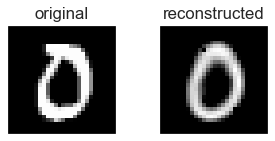

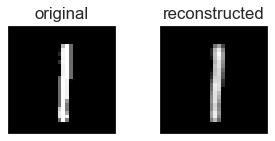

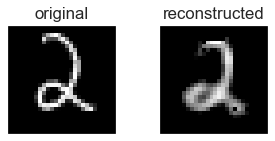

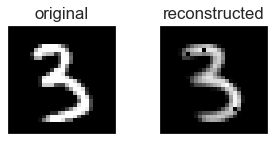

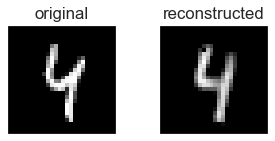

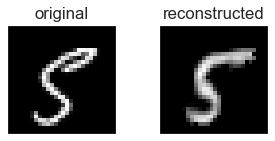

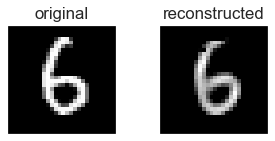

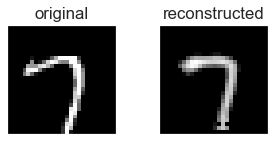

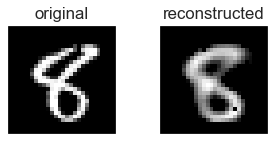

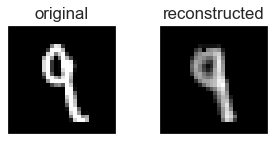

In [75]:
#Plotting the figures
for i in range(10):
    plt.figure(figsize=(5, 2))
    
    ax = plt.subplot(1, 2, 1)
    plt.imshow(original_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('original')
    
    ax = plt.subplot(1, 2, 2)
    plt.imshow(images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('reconstructed')